In [2]:
from tbsim.utils.scene_edit_utils import UnifiedRenderer
import numpy as np
%matplotlib inline  

import argparse
import seaborn as sns
import  sys
import pytorch_lightning as pl
import torch
from tbsim.utils.log_utils import PrintLogger
from tbsim.utils.batch_utils import set_global_batch_type
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
import tbsim.utils.train_utils as TrainUtils
from tbsim.datasets.factory import datamodule_factory
from tbsim.utils.env_utils import RolloutCallback

import wandb,json
from pytorch_lightning.loggers import  WandbLogger
from  models.algos import  UnifiedTrainer
from datetime import  datetime
from configs.custom_config import dict_to_config,ConfigBase,serialize_object
from src.tbsim.configs.base import ExperimentConfig
import yaml
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

from torch.utils.data import DataLoader
from tqdm import tqdm

from trajdata import AgentBatch, AgentType, UnifiedDataset
from trajdata.augmentation import NoiseHistories
from trajdata.visualization.vis import plot_agent_batch


SyntaxError: invalid syntax (vae.py, line 76)

In [ ]:
parser = argparse.ArgumentParser(description="Training Script")
parser.add_argument("--config", type=str, default="/home/visier/hazardforge/HazardForge/config.yaml", help="Path to YAML config")

# 直接使用默认值解析参数
args = parser.parse_args([])  # 在 Notebook 中使用 [] 表示不传递命令行参数

# 加载配置文件
with open(args.config, "r") as f:
    config_dict = yaml.safe_load(f)
train_config = dict_to_config(ConfigBase, config_dict.get("train", {}))
env_config = dict_to_config(ConfigBase, config_dict.get("env", {}))
algo_config = dict_to_config(ConfigBase, config_dict.get("algo", {}))
default_config = ExperimentConfig(
        train_config=train_config,
        env_config=env_config,
        algo_config=algo_config,
        registered_name=config_dict.get("registered_name", "default_experiment"),
    )
if default_config.train.rollout.get("enabled", False):
        default_config.env["eval"] = {"env": default_config.env["name"]}
        assert default_config.algo["eval_class"], f"Please set an eval_class for {default_config.algo['name']}"
        default_config.env["eval"]["eval_class"] = default_config.algo["eval_class"]
        default_config.env["eval"]["dataset_path"] = default_config.train["trajdata_data_dirs"]["nusc_trainval"]
        env_specific_config = default_config.env.get(default_config.env["eval"]["env"], {})
        for key, value in env_specific_config.items():
            default_config.env["eval"][key] = value
default_config.lock()
cfg = default_config
pl.seed_everything(cfg.seed)
set_global_batch_type("trajdata")
set_global_trajdata_batch_env(cfg.train.trajdata_source_train[0])
set_global_trajdata_batch_raster_cfg(cfg.env.rasterizer)
print("\n============= New Training Run with Config =============")


In [ ]:
datamodule = datamodule_factory(
        cls_name=cfg.train.datamodule_class, config=cfg
    )

datamodule.setup()


In [14]:
dataset = datamodule.train_dataset
print(f"# Data Samples: {len(dataset):,}")
dataloader = datamodule.train_dataloader()


# Data Samples: 10,724


In [150]:
batch = next(iter(dataloader))
batch_idx=0


StateArrayXYXdYdXddYddH([ 1.7852346e+03,  8.7469098e+02,  2.7600000e-02,
                          4.8400000e-02, -1.3600000e-02,  2.6960000e-01,
                         -3.1037629e+00], dtype=float32)

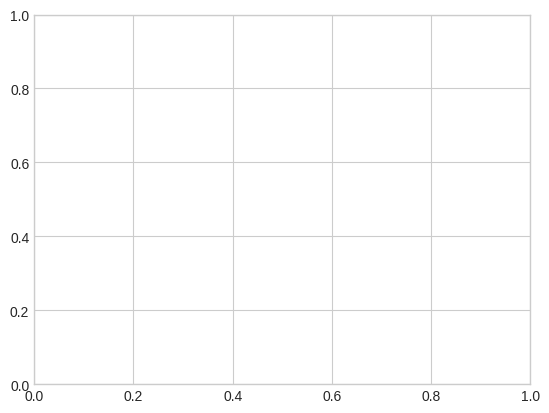

In [152]:
%matplotlib inline
import matplotlib.transforms as mtransforms
_, ax = plt.subplots()
agent_name: str = batch["agent_name"]
agent_type = batch["agent_type"]
current_state = batch["curr_agent_state"][0].numpy()
# ax.set_title(
#         f"{str(agent_type)}/{agent_name}\nat x={current_state[0]:.2f},y={current_state[1]:.2f},h={current_state[-1]:.2f}"
#     )
# agent_from_world_tf= batch["agents_from_world_tf"][batch_idx].cpu()
# world_from_raster_tf= torch.linalg.inv(batch["rasters_from_world_tf"][batch_idx].cpu())

# agent_from_raster_tf= agent_from_world_tf @ world_from_raster_tf
# map = batch["maps"][batch_idx]
# patch_size = map.shape[-1]
# map_array = map.cpu().permute(1, 2, 0).numpy()

# im=ax.imshow(map_array,extent=[0, patch_size, patch_size, 0],clip_on=False)
# agent_hist = batch['agent_hist'][batch_idx].cpu()
# agent_fut = batch['agent_fut'][batch_idx].cpu()
# agent_extent = batch['agent_hist_extent'][batch_idx, -1, :].cpu()
# base_frame_from_agent_tf = torch.eye(3)
# palette = sns.color_palette("husl", 4)
# color = palette[0]
# T = agent_hist.shape[0]#31
# alphas = np.linspace(0.2, 0.5, T)

# from trajdata.visualization.vis import draw_agent
# # for t in range(T):
# draw_agent(
#     ax,
#     agent_type,
#     agent_hist[0],
#     agent_extent+torch.tensor([0,0,np.pi/2]),
#     base_frame_from_agent_tf,
    
# )
current_state
